<a href="https://colab.research.google.com/github/virendra-978/Skin-disease-detection/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"virendra978","key":"51644d89725af6f173de132508712064"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip skin-cancer-mnist-ham10000.zip -d ham10000


Streaming output truncated to the last 5000 lines.
  inflating: ham10000/ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000/ham10000_images_part_2/ISIC_002

In [6]:
import os
import shutil
import pandas as pd

# Paths
metadata_path = "/content/ham10000/HAM10000_metadata.csv"
image_dir_1 = "/content/ham10000/HAM10000_images_part_1"
image_dir_2 = "/content/ham10000/HAM10000_images_part_2"
output_dir = "/content/skin_images"

# Load metadata
df = pd.read_csv(metadata_path)

# Mapping dx to readable names (optional)
label_map = {
    'nv': 'melanocytic_nevi',
    'mel': 'melanoma',
    'bkl': 'benign_keratosis',
    'bcc': 'basal_cell_carcinoma',
    'akiec': 'actinic_keratoses',
    'vasc': 'vascular_lesions',
    'df': 'dermatofibroma'
}

# Create output folders
os.makedirs(output_dir, exist_ok=True)
for label in label_map.values():
    os.makedirs(os.path.join(output_dir, label), exist_ok=True)

# Move images to their class folders
image_id_to_path = {}

# Combine image paths from both folders
for folder in [image_dir_1, image_dir_2]:
    for fname in os.listdir(folder):
        image_id = fname.split(".")[0]
        image_id_to_path[image_id] = os.path.join(folder, fname)

# Copy images to label folders
for _, row in df.iterrows():
    img_id = row["image_id"]
    label = label_map[row["dx"]]
    src_path = image_id_to_path.get(img_id)
    dst_path = os.path.join(output_dir, label, f"{img_id}.jpg")

    if src_path and os.path.exists(src_path):
        shutil.copy(src_path, dst_path)

print("✅ Dataset organized into:", output_dir)


✅ Dataset organized into: /content/skin_images


In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import load_model


In [8]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 10  # You can increase if you want
DATASET_PATH = "/content/skin_images"


In [9]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 8015 images belonging to 7 classes.
Found 2000 images belonging to 7 classes.


In [10]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,393,223 (28.20 MB)

 Trainable params: 7,393,223 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen
)


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 285s 1s/step - accuracy: 0.7087 - loss: 0.7945 - val_accuracy: 0.7240 - val_loss: 0.7336
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 297s 1s/step - accuracy: 0.7123 - loss: 0.7641 - val_accuracy: 0.7310 - val_loss: 0.7216
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - accuracy: 0.7221 - loss: 0.7559 - val_accuracy: 0.7150 - val_loss: 0.7539
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - accuracy: 0.7116 - loss: 0.7699 - val_accuracy: 0.7385 - val_loss: 0.6992
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 278s 1s/step - accuracy: 0.7212 - loss: 0.7476 - val_accuracy: 0.7275 - val_loss: 0.7082
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 281s 1s/step - accuracy: 0.7161 - loss: 0.7512 - val_accuracy: 0.7325 - val_loss: 0.7222
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 274s 1s/step - accuracy: 0.7198 - loss: 0.7271 - val_accuracy: 0.7435 - val_loss: 0.7605
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 282s 1s/step - accuracy: 0.7229 - loss: 0.7429 - val_accu

In [14]:
model.save("/content/skin_disease_model.h5")
print("✅ Model saved to /content/skin_disease_model.h5")


✅ Model saved to /content/skin_disease_model.h5


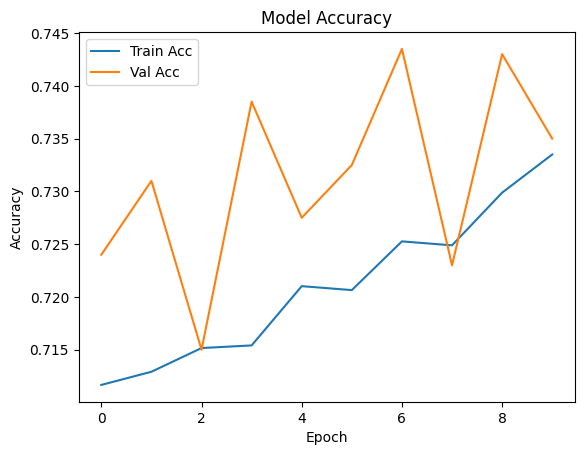

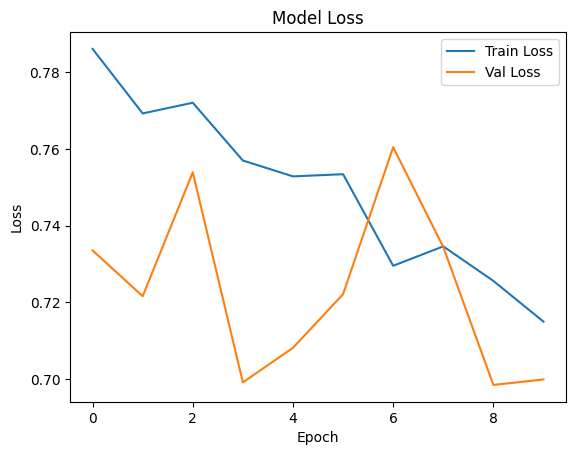

In [15]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [16]:
def predict_image(img_path):
    model = load_model("/content/skin_disease_model.h5")
    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    class_indices = train_gen.class_indices
    label_map = dict((v, k) for k, v in class_indices.items())
    predicted_label = label_map[predicted_class]

    print(f"Predicted Class: {predicted_label}")
    print(f"Confidence: {np.max(prediction):.2f}")


In [18]:
# Example: give path to an image
predict_image("/content/skin_images/melanoma/ISIC_0027149.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
Predicted Class: melanocytic_nevi
Confidence: 0.61
